In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, cohen_kappa_score
from xgboost import XGBRegressor, XGBClassifier
from typing import Optional, List, Dict, Tuple

warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn")

In [2]:
df = pd.read_csv(r"/Users/loganheydt/Documents/GitHub/Kaggle_competitions/Wine_Quality/data/train.csv")

In [3]:
df_raw = df.copy()

Y = df_raw['quality']
X = df_raw.drop(columns=['quality', 'id'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=42)

# Data Exploration

In [4]:
df.describe()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,8.150407,0.506026,0.229651,2.185944,0.078890,13.041077,36.893967,0.996907,3.323941,0.618216,10.183854,5.652467
std,4330.271354,1.389280,0.135077,0.178647,0.521511,0.014986,7.843052,23.956718,0.001392,0.116201,0.107910,0.900769,0.814861
min,0.000000,3.500000,0.180000,0.000000,1.100000,0.012000,0.650000,5.000000,0.990640,2.790000,0.400000,8.100000,3.000000
25%,3749.750000,7.200000,0.400000,0.050000,1.900000,0.073000,6.000000,19.000000,0.995880,3.240000,0.550000,9.500000,5.000000
50%,7499.500000,7.800000,0.510000,0.240000,2.100000,0.078000,11.000000,29.000000,0.996800,3.320000,0.590000,9.800000,6.000000
75%,11249.250000,8.900000,0.600000,0.370000,2.300000,0.084000,17.000000,48.000000,0.997800,3.390000,0.660000,10.800000,6.000000
max,14999.000000,15.800000,1.740000,0.770000,13.300000,0.415000,52.000000,152.000000,1.003690,4.010000,1.950000,15.000000,8.000000


In [5]:
missing = df.isnull().sum()

In [6]:
def quadratic_correlation_table(df, target, features):
    results = []

    y = df[target].values.reshape(-1, 1)

    for col in features:
        X = df[[col]].values

        # --- Linear ---
        lin_model = LinearRegression()
        lin_model.fit(X, y)
        lin_r2 = lin_model.score(X, y)

        # --- Quadratic ---
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X)

        quad_model = LinearRegression()
        quad_model.fit(X_poly, y)
        quad_r2 = quad_model.score(X_poly, y)

        results.append({
            "feature": col,
            "linear_r2": lin_r2,
            "quadratic_r2": quad_r2,
            "improvement": quad_r2 - lin_r2
        })

    return pd.DataFrame(results).sort_values("quadratic_r2", ascending=True)

In [7]:
features = df.columns.tolist()
features = [col for col in features if col not in ['id', 'quality']]

results_df = quadratic_correlation_table(df, target='quality', features=features)

print(results_df.sort_values("improvement", ascending=False))

                 feature  linear_r2  quadratic_r2  improvement
0          fixed acidity   0.003057      0.007637     0.004581
9              sulphates   0.000729      0.002607     0.001878
2            citric acid   0.001107      0.002852     0.001744
1       volatile acidity   0.000257      0.001336     0.001079
10               alcohol   0.167449      0.167833     0.000384
8                     pH   0.000392      0.000624     0.000231
7                density   0.001206      0.001409     0.000203
4              chlorides   0.000032      0.000231     0.000199
6   total sulfur dioxide   0.008737      0.008905     0.000168
3         residual sugar   0.001687      0.001781     0.000094
5    free sulfur dioxide   0.001417      0.001443     0.000026


#### Disproves the idea of quadratic correlation ^^

In [8]:
interactions = [
    # ['volatile acidity', 'total sulfur dioxide'],
    ['citric acid', 'residual sugar'],
    # ['volatile acidity', 'residual sugar'],
    ['fixed acidity', 'residual sugar'],
    ['chlorides', 'alcohol'],
    ['chlorides', 'volatile acidity'],
    ['chlorides', 'fixed acidity'],
    ['chlorides', 'citric acid'],
    # ['total sulfur dioxide','residual sugar'],
    ['total sulfur dioxide', 'pH']
]

In [9]:
for f1, f2 in interactions:
    df[f'{f1}__x__{f2}'] = df[f1] * df[f2]

for f1, f2 in interactions:
    df[f'{f1}__-__{f2}'] = df[f1] - df[f2]

eps = 1e-6

for f1, f2 in interactions:
    df[f'{f1}__/__{f2}'] = df[f1] / (df[f2] + eps)

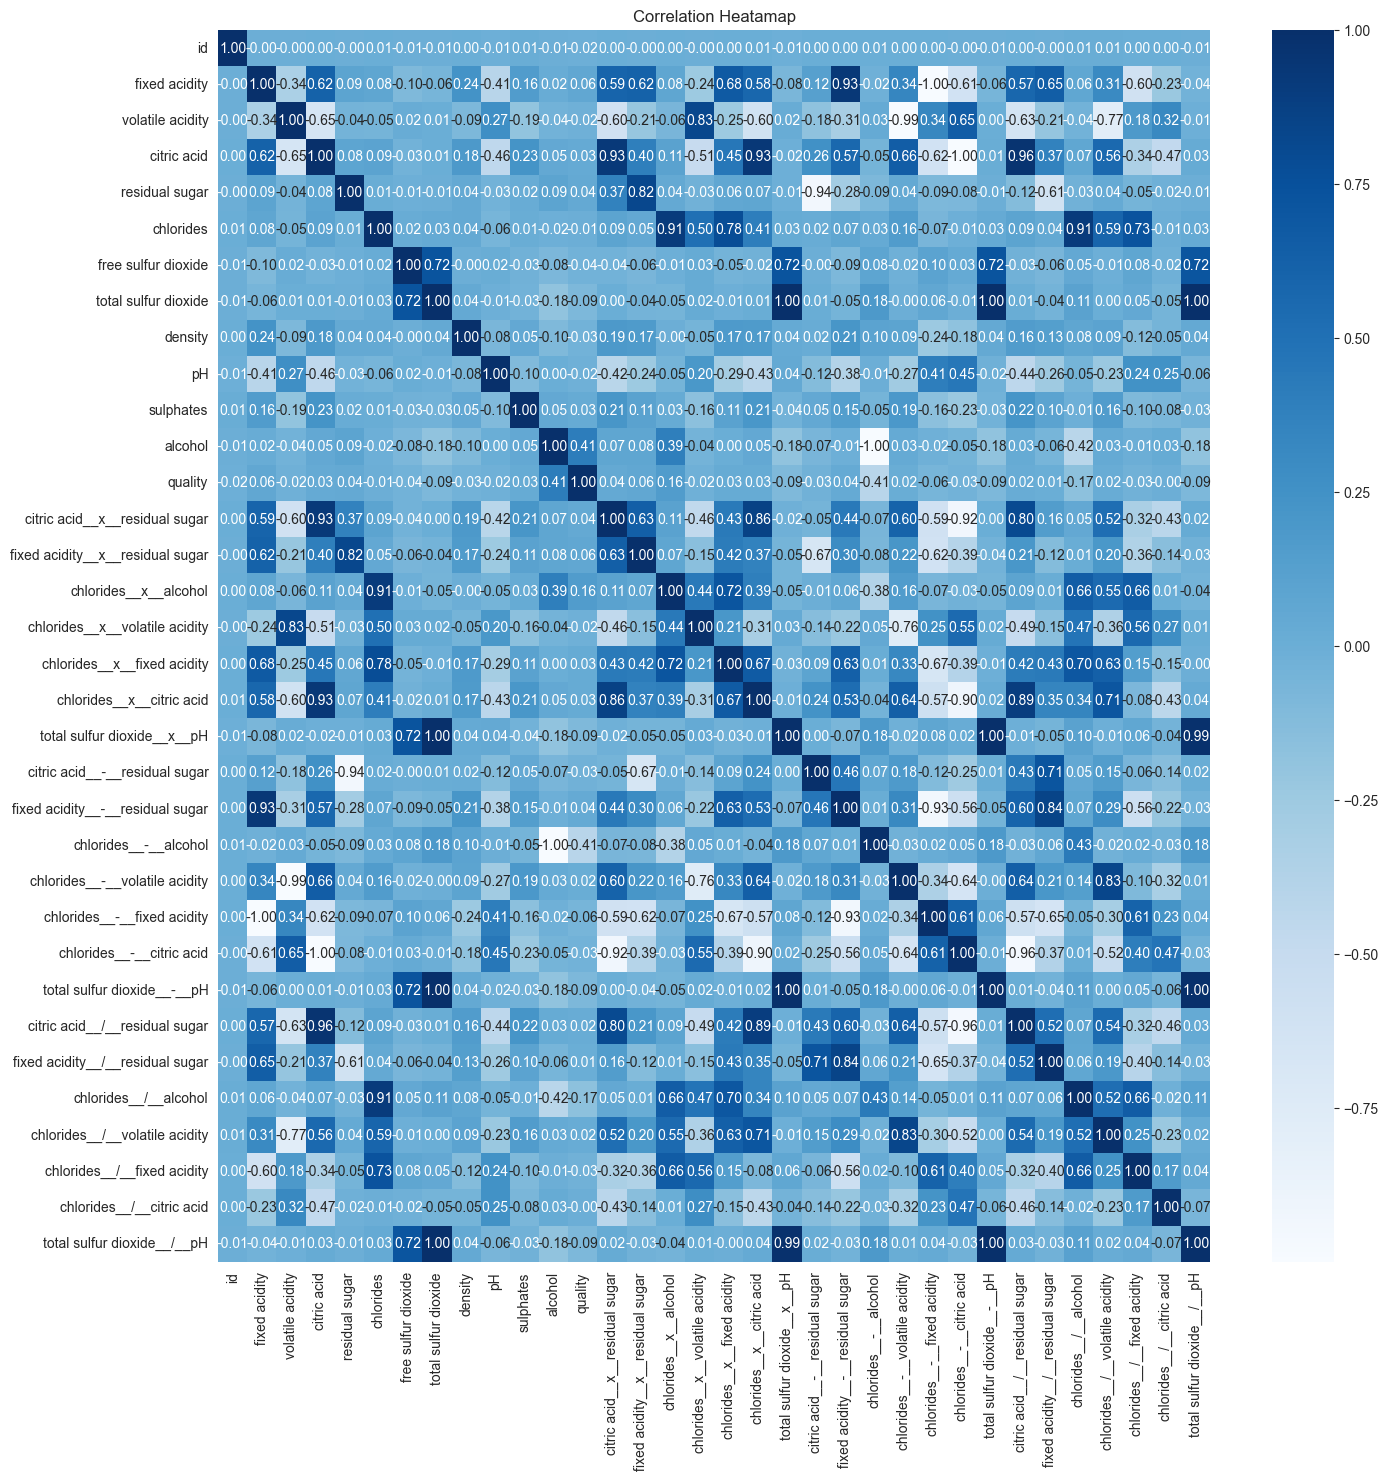

In [10]:
plt.figure(figsize=(16,16))
corr =  df.corr()
sns.heatmap(corr, cmap='Blues', annot=True, fmt=".2f")
plt.title("Correlation Heatamap")
plt.show()

In [11]:
for column in features:
    print(df.groupby(pd.qcut(df[column], 6), observed=False)['quality'].mean())

fixed acidity
(3.499, 7.0]    5.705366
(7.0, 7.4]      5.603920
(7.4, 7.8]      5.558681
(7.8, 8.4]      5.618366
(8.4, 9.3]      5.629052
(9.3, 15.8]     5.781557
Name: quality, dtype: float64
volatile acidity
(0.179, 0.36]    5.705906
(0.36, 0.43]     5.650933
(0.43, 0.51]     5.638991
(0.51, 0.58]     5.619993
(0.58, 0.64]     5.645033
(0.64, 1.74]     5.655429
Name: quality, dtype: float64
citric acid
(-0.001, 0.02]    5.642057
(0.02, 0.1]       5.668159
(0.1, 0.24]       5.611876
(0.24, 0.31]      5.600219
(0.31, 0.44]      5.661382
(0.44, 0.77]      5.738244
Name: quality, dtype: float64
residual sugar
(1.0990000000000002, 1.8]    5.608532
(1.8, 2.0]                   5.612420
(2.0, 2.1]                   5.693917
(2.1, 2.3]                   5.657468
(2.3, 2.5]                   5.695255
(2.5, 13.3]                  5.696340
Name: quality, dtype: float64
chlorides
(0.011, 0.07]     5.693525
(0.07, 0.075]     5.644363
(0.075, 0.078]    5.633646
(0.078, 0.081]    5.618665
(0.081, 

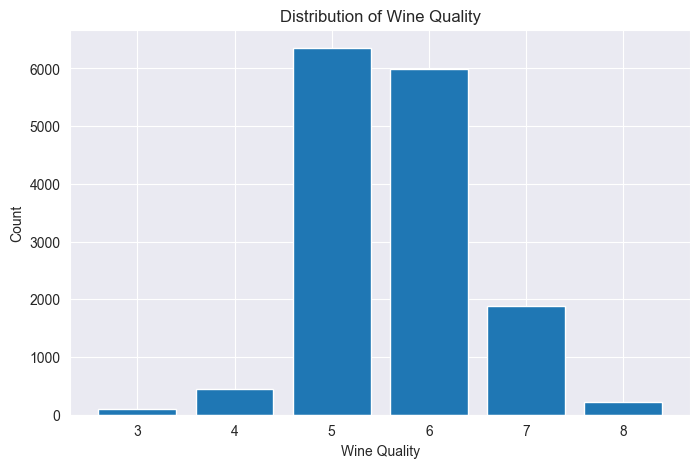

In [12]:
quality_counts = df['quality'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(quality_counts.index, quality_counts.values)
plt.xlabel("Wine Quality")
plt.ylabel("Count")
plt.title("Distribution of Wine Quality")
plt.xticks(quality_counts.index)
plt.show()

# Model Exploration

In [13]:
y = df['quality']
x = df.drop(columns=['quality', 'id'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)

In [14]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=-1
)
model.fit(x_train, y_train)

perm = permutation_importance(
    model, x_test, y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

imp = (pd.DataFrame({
    "feature": x_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
})
.sort_values("importance_mean", ascending=False))

imp.head(15)

,feature,importance_mean,importance_std
20,chlorides__-__alcohol,0.118914,0.008102
10,alcohol,0.051996,0.005496
31,total sulfur dioxide__/__pH,0.014860,0.002924
26,fixed acidity__/__residual sugar,0.013757,0.001669
25,citric acid__/__residual sugar,0.010135,0.002989
5,free sulfur dioxide,0.008303,0.002297
24,total sulfur dioxide__-__pH,0.006234,0.001599
11,citric acid__x__residual sugar,0.005400,0.001836
8,pH,0.004637,0.002011
29,chlorides__/__fixed acidity,0.004081,0.001441


In [15]:
def evaluate_feature_set(feature_list, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    rmse_scores = []
    qwk_scores = []

    for train_idx, val_idx in kf.split(X):
        x_train, x_val = X.iloc[train_idx][feature_list], X.iloc[val_idx][feature_list]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

        model.fit(x_train, y_train)
        preds = model.predict(x_val)

        # RMSE
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

        # QWK (round predictions first)
        preds_rounded = np.clip(np.round(preds), y.min(), y.max())
        qwk = cohen_kappa_score(y_val, preds_rounded, weights="quadratic")
        qwk_scores.append(qwk)

    return {
        "RMSE_mean": np.mean(rmse_scores),
        "RMSE_std": np.std(rmse_scores),
        "QWK_mean": np.mean(qwk_scores),
        "QWK_std": np.std(qwk_scores)
    }

In [16]:
X_full = df.drop(columns=["quality"])

sub_features = [c for c in X_full.columns if "__-__" in c]

div_features = [c for c in X_full.columns if "__/__" in c]

raw_features = [
    c for c in X_full.columns
    if "__-__" not in c and "__/__" not in c and "__x__" not in c
]

In [17]:
results_raw = evaluate_feature_set(raw_features, X_full, y)

In [18]:
features_sub = raw_features + sub_features
results_sub = evaluate_feature_set(features_sub, X_full, y)

In [19]:
features_sub_div = raw_features + sub_features + div_features
results_sub_div = evaluate_feature_set(features_sub_div, X_full, y)

In [20]:
print("Raw only:", results_raw)
print("Raw + subtraction:", results_sub)
print("Raw + subtraction + division:", results_sub_div)

Raw only: {'RMSE_mean': np.float64(0.7412557558709085), 'RMSE_std': np.float64(0.009379636350163216), 'QWK_mean': np.float64(0.31206012656943083), 'QWK_std': np.float64(0.013210346497240696)}
Raw + subtraction: {'RMSE_mean': np.float64(0.7417978823520797), 'RMSE_std': np.float64(0.009596161050197565), 'QWK_mean': np.float64(0.31531590542140164), 'QWK_std': np.float64(0.016275010533589474)}
Raw + subtraction + division: {'RMSE_mean': np.float64(0.742914062761946), 'RMSE_std': np.float64(0.010097007475136555), 'QWK_mean': np.float64(0.3174754839803651), 'QWK_std': np.float64(0.017976934739963892)}


### Thus far in the model exploration, I have determined that the interactions add minimal benefit with added complication.


### Trying ordinal cumulative modeling here.

In [21]:
classes = sorted(Y.unique())
print(classes)

[np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0)]


In [22]:
def _enforce_monotone_decreasing(probs_ge: np.ndarray) -> np.ndarray:
    """
    probs_ge: (n_samples, n_thresholds) for P(y >= t) over increasing thresholds t
    Enforce: P(y>=t1) >= P(y>=t2) >= ...
    """
    return np.minimum.accumulate(probs_ge[:, ::-1], axis=1)[:, ::-1]


def _predict_from_cumulative_probs(
    probs_ge: np.ndarray,
    classes: List[int],
    rule: str = "max_delta",
) -> np.ndarray:
    """
    Convert cumulative probabilities P(y >= t) into an ordinal class prediction.

    rule:
      - "0.5": count thresholds where prob > 0.5
      - "max_delta": reconstruct P(y=class) from cumulative probs and argmax
    """
    probs_ge = _enforce_monotone_decreasing(probs_ge)

    if rule == "0.5":
        k = (probs_ge > 0.5).sum(axis=1)
        preds = np.array(classes[0], dtype=float) + k
        return preds.astype(int)

    if rule == "max_delta":
        # If classes = [c0, c1, ..., cM], thresholds correspond to >= c1..cM
        # p_ge[:,0]=P(y>=c1), p_ge[:,1]=P(y>=c2), ...
        p_ge = probs_ge
        n = p_ge.shape[0]
        m = len(classes)

        p_cls = np.zeros((n, m), dtype=float)
        p_cls[:, 0] = 1.0 - p_ge[:, 0]
        for i in range(1, m - 1):
            p_cls[:, i] = p_ge[:, i - 1] - p_ge[:, i]
        p_cls[:, -1] = p_ge[:, -1]

        preds = np.array(classes)[np.argmax(p_cls, axis=1)]
        return preds.astype(int)

    raise ValueError("rule must be '0.5' or 'max_delta'")


def ordinal_cumulative_cv(
    df: pd.DataFrame,
    target_col: str = "quality",
    drop_cols: Optional[List[str]] = None,
    n_splits: int = 5,
    seed: int = 42,
    predict_rule: str = "max_delta",
    xgb_params: Optional[Dict] = None,
) -> Tuple[Dict, pd.DataFrame, np.ndarray]:
    """
    K-fold CV for ordinal cumulative transformation using one XGBClassifier per threshold.
    Returns: (summary_results_dict, per_fold_df, oof_preds)
    """
    df_model = df.copy()

    if drop_cols is None:
        drop_cols = []

    # always drop id if present unless user already included it
    if "id" in df_model.columns and "id" not in drop_cols:
        drop_cols = drop_cols + ["id"]

    y = df_model[target_col].astype(int)
    X = df_model.drop(columns=[target_col] + drop_cols, errors="ignore")

    # Clean non-finite values (inf/-inf -> NaN). XGB handles NaN.
    X = X.replace([np.inf, -np.inf], np.nan)

    classes = sorted(y.unique().tolist())
    thresholds = classes[1:]  # model P(y >= t) for each threshold t

    if xgb_params is None:
        xgb_params = dict(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=seed,
            n_jobs=-1,
            eval_metric="logloss",
        )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    fold_rows = []
    oof_preds = np.empty(len(df_model), dtype=int)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        # Fit one classifier per threshold
        models = {}
        for t in thresholds:
            y_bin = (y_tr >= t).astype(int)
            pos_weight = (len(y_bin) - y_bin.sum()) / y_bin.sum()
            clf = XGBClassifier(
                **xgb_params,
                scale_pos_weight=pos_weight)
            clf.fit(X_tr, y_bin)
            models[t] = clf

        # Predict cumulative probs on validation
        probs_list = []
        for t in thresholds:
            probs_list.append(models[t].predict_proba(X_va)[:, 1])

        probs_ge = np.vstack(probs_list).T  # (n_val, n_thresholds)

        y_hat = _predict_from_cumulative_probs(
            probs_ge=probs_ge,
            classes=classes,
            rule=predict_rule,
        )

        oof_preds[val_idx] = y_hat

        qwk = cohen_kappa_score(y_va, y_hat, weights="quadratic")
        rmse = np.sqrt(mean_squared_error(y_va, y_hat.astype(float)))

        fold_rows.append({"fold": fold, "qwk": qwk, "rmse": rmse, "n_val": len(val_idx)})

    folds_df = pd.DataFrame(fold_rows)

    results = {
        "n_splits": n_splits,
        "classes": classes,
        "thresholds": thresholds,
        "predict_rule": predict_rule,
        "QWK_mean": float(folds_df["qwk"].mean()),
        "QWK_std": float(folds_df["qwk"].std(ddof=0)),
        "RMSE_mean": float(folds_df["rmse"].mean()),
        "RMSE_std": float(folds_df["rmse"].std(ddof=0)),
    }

    return results, folds_df, oof_preds

In [23]:
results, folds, oof = ordinal_cumulative_cv(df, target_col="quality", drop_cols=["id"])
print(results)
display(folds)

{'n_splits': 5, 'classes': [3, 4, 5, 6, 7, 8], 'thresholds': [4, 5, 6, 7, 8], 'predict_rule': 'max_delta', 'QWK_mean': 0.0018499960252131408, 'QWK_std': 0.0012109750959582721, 'RMSE_mean': 2.7710282979109198, 'RMSE_std': 0.01639630579056189}


,fold,qwk,rmse,n_val
0,1,0.001403,2.790102,3000
1,2,0.003328,2.790400,3000
2,3,0.003245,2.766225,3000
3,4,0.000810,2.751363,3000
4,5,0.000464,2.757052,3000


### Ordinal cumulative modeling doesn't work because there is such a large portion of the training data that is rated either 5 or 6 with noisy, not very sharp boundaries across the quality ratings.


Next step is to try using a regressor to produce a quality score and use optimal cutpoints to maximize QWK. Instead of rounding, where we are assuming equal spacing between classes (rounding), there are uneven cutpoints.

In [24]:
def apply_thresholds(scores, thresholds, min_class=3):
    """
    thresholds: increasing list-like of length K-1 (for K classes)
    returns integer classes in [min_class, min_class+K-1]
    """
    thresholds = np.asarray(thresholds)
    return (np.digitize(scores, thresholds) + min_class).astype(int)

In [25]:
def optimize_thresholds(scores, y_true, classes=(3,4,5,6,7,8), n_iter=30):
    """
    Learn thresholds to maximize QWK given continuous scores.
    Uses coordinate descent over thresholds.
    """
    classes = list(classes)
    min_c, max_c = classes[0], classes[-1]
    k = len(classes)

    # initialize thresholds as quantiles based on class count
    qs = np.linspace(0, 1, k+1)[1:-1]
    thr = np.quantile(scores, qs)

    def qwk_for(thr_):
        preds = apply_thresholds(scores, thr_, min_class=min_c)
        preds = np.clip(preds, min_c, max_c)
        return cohen_kappa_score(y_true, preds, weights="quadratic")

    best = qwk_for(thr)

    # coordinate descent: tweak one threshold at a time
    for _ in range(n_iter):
        improved = False
        for i in range(len(thr)):
            # search around current threshold using candidate values from score percentiles
            # (cheap and robust)
            cand = np.quantile(scores, np.linspace(0.05, 0.95, 41))
            cand = cand[(cand > (thr[i-1] if i > 0 else -np.inf)) &
                        (cand < (thr[i+1] if i < len(thr)-1 else np.inf))]
            if len(cand) == 0:
                continue

            local_best_thr = thr[i]
            local_best = best

            for v in cand:
                thr_try = thr.copy()
                thr_try[i] = v
                val = qwk_for(thr_try)
                if val > local_best:
                    local_best = val
                    local_best_thr = v

            if local_best > best:
                thr[i] = local_best_thr
                best = local_best
                improved = True

        if not improved:
            break

    return thr, best

In [26]:
def cv_regression_with_qwk_thresholds(df, target_col="quality", drop_cols=None, n_splits=5, seed=42):
    if drop_cols is None:
        drop_cols = []
    if "id" in df.columns and "id" not in drop_cols:
        drop_cols = drop_cols + ["id"]

    y = df[target_col].astype(int)
    X = df.drop(columns=[target_col] + drop_cols, errors="ignore").replace([np.inf, -np.inf], np.nan)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    rows = []
    for fold, (tr, va) in enumerate(kf.split(X), start=1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        model = XGBRegressor(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=seed,
            n_jobs=-1
        )
        model.fit(X_tr, y_tr)

        # continuous scores
        s_tr = model.predict(X_tr)
        s_va = model.predict(X_va)

        # learn thresholds on TRAIN fold to maximize QWK
        thr, train_qwk = optimize_thresholds(s_tr, y_tr.values, classes=tuple(sorted(y.unique())))

        # apply thresholds to VAL fold
        pred_va = apply_thresholds(s_va, thr, min_class=int(y.min()))
        qwk = cohen_kappa_score(y_va, pred_va, weights="quadratic")
        rmse = np.sqrt(mean_squared_error(y_va, pred_va.astype(float)))

        rows.append({"fold": fold, "train_qwk": train_qwk, "val_qwk": qwk, "val_rmse": rmse})

    out = pd.DataFrame(rows)
    summary = {
        "QWK_mean": float(out["val_qwk"].mean()),
        "QWK_std": float(out["val_qwk"].std(ddof=0)),
        "RMSE_mean": float(out["val_rmse"].mean()),
        "RMSE_std": float(out["val_rmse"].std(ddof=0)),
    }
    return summary, out

In [27]:
summary, folds = cv_regression_with_qwk_thresholds(df, target_col="quality", drop_cols=["id"])
print(summary)
display(folds)

{'QWK_mean': 0.34560583948908274, 'QWK_std': 0.016567679853413068, 'RMSE_mean': 1.0040116714008431, 'RMSE_std': 0.017143425101729958}


,fold,train_qwk,val_qwk,val_rmse
0,1,0.658316,0.318033,1.025671
1,2,0.659443,0.369095,0.984547
2,3,0.656910,0.352320,0.988096
3,4,0.656154,0.346733,0.999166
4,5,0.654615,0.341849,1.022578


# Wine Notes
## Fixed acidity:
 Acids that do not evaporate easily
 - too low -> dull wine
 - too high -> sour

** Maybe a quadratic correlation to quality? **

## Volatile Acidity:
Vinegar like acid -> undesirable
Sulfur dioxides helps suppress

** Combine this field with total sulfur dioxide **

## Citric Acid:
Minor acid naturally present in grapes, adds brightness

** Can balance residual sugars **

## Residual Sugars:
Sugar remaining after fermentation process
- Sweet wines: high residual sugar
- Dry wines: low residual sugar

** Balance with acidity **

## Chlorides:
Salt content
- Low amounts: minerality
- High amount: harsh and metalic

** Could interact with alcohol and acidity in mouthfeel perception **

## Free Sulfur Dioxide:
antimicrobial + antioxident
- Too little -> spoils
- Too much -> chemical smell

Helps with sweeter wines

** Counterbalanced by pH levels **

## Total Sulfur Dioxide:
Free Sulfar Dioxide + Bound Sulfur Dioxides
- Acts as preservative
- Helps with sweeter wines

** Could consider interacting with residual sugars **

## Density:
Mass per volume, drivers:
- Sugars increase density
- Alcohol decreases density

## pH:
Measure of acidity strength
- Lower means stronger acidity, brighter and fresher
- Higher leads to a duller wine

Reds are best between 3.3-3.6
Whites are best between 3.0-3.3

** Effects sulfur dioxide effectiveness **

##  Sulphates:
Winemaking additives that enhance micorbials
- moderate levels associated with higher quality

** Maybe a quadratic correlation to quality? **

